In [1]:
AUTHOR_NAME = 'Jane Deijnen'
AUTHOR_ID_NR = '1354396'
AUTHOR_DATE = '2020-05-05'

AUTHOR_NAME, AUTHOR_ID_NR, AUTHOR_DATE

('Jane Deijnen', '1354396', '2020-05-05')

In [28]:
import numpy as np
import pandas as pd
import bokeh as bk
import random

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
sns.set()  # set Seaborn defaults
plt.rcParams['figure.figsize'] = 10, 5  # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed after import seaborn
from sklearn.cluster import KMeans  # for clustering

from bokeh.io import output_notebook, show, reset_output, curdoc
from bokeh.models import Slider, CustomJS
from bokeh.plotting import figure
from bokeh.layouts import layout, column
from bokeh.models import (
    ColumnDataSource, Div,
    HoverTool,
    LinearColorMapper,
    BasicTicker,
    PrintfTickFormatter,
    ColorBar,
    FactorRange
)
from bokeh.palettes import BuPu
from bokeh.palettes import Spectral6
output_notebook()

Loading BokehJS ...

In [3]:
eyetracking_data = pd.read_csv('metro_data.csv', encoding = 'latin1', sep = ";")
eyetracking_data.head()

,Timestamp,StimuliName,FixationIndex,FixationDuration,MappedFixationPointX,MappedFixationPointY,user,description
0,2586,01_Antwerpen_S1.jpg,9,250,1151,458,p1,color
1,2836,01_Antwerpen_S1.jpg,10,150,1371,316,p1,color
2,2986,01_Antwerpen_S1.jpg,11,283,1342,287,p1,color
3,3269,01_Antwerpen_S1.jpg,12,433,762,303,p1,color
4,3702,01_Antwerpen_S1.jpg,13,183,624,297,p1,color


In [4]:
#dataframe of Antwerper_s1 stimulus only
Antwerpen_s1 = eyetracking_data[eyetracking_data['StimuliName'] == '01_Antwerpen_S1.jpg']
Antwerpen_s1.head()

,Timestamp,StimuliName,FixationIndex,FixationDuration,MappedFixationPointX,MappedFixationPointY,user,description
0,2586,01_Antwerpen_S1.jpg,9,250,1151,458,p1,color
1,2836,01_Antwerpen_S1.jpg,10,150,1371,316,p1,color
2,2986,01_Antwerpen_S1.jpg,11,283,1342,287,p1,color
3,3269,01_Antwerpen_S1.jpg,12,433,762,303,p1,color
4,3702,01_Antwerpen_S1.jpg,13,183,624,297,p1,color


In [5]:
n_clusters = int(input()) #could become slider option

3


In [6]:
#k-means clustering algorithm
X_km = Antwerpen_s1[['MappedFixationPointX', 'MappedFixationPointY']].copy()
km = KMeans(n_clusters)
km.fit(X_km)
centers = pd.DataFrame(km.cluster_centers_, columns=X_km.columns)
X_km['cluster'] = km.labels_

user = Antwerpen_s1["user"]
X_km = X_km.join(user)
X_km = X_km.reset_index()


In [7]:
#adjust cluster column
X_km_adj = X_km.copy()

for i in range(X_km.index[-1]+1):
    X_km_adj.loc[i, 'cluster'] = X_km_adj['cluster'][i]+1

X_km_adj.head()

,index,MappedFixationPointX,MappedFixationPointY,cluster,user
0,0,1151,458,1,p1
1,1,1371,316,1,p1
2,2,1342,287,1,p1
3,3,762,303,3,p1
4,4,624,297,3,p1


In [8]:
#have to make sure there are enough color options for the clusters
colors = ['red', 'orange', 'green', 'blue', 'purple', 'magenta', 'darkgreen']
colorlist =[]

for i in range(X_km.index[-1]+1):
    index = X_km['cluster'][i]
    colorlist.append(colors[index])

In [26]:
#AOI map (still need to make a X_km copy in which cluster 0=1, 1=2, etc. to make the legend correct)
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select"
TOOLTIPS=[("Participant", "@u"),
          ("AOI", "@c"),
         ("X-coordinate", "@x"),
         ("Y-coordinate", "@y")
         ]

x = list(X_km_adj['MappedFixationPointX'])
y = list(X_km_adj['MappedFixationPointY'])
c = list(X_km_adj['cluster'])
u = list(X_km_adj['user'])

source = ColumnDataSource(data=dict(x=x, y=y, c=c, u=u, color=colorlist))
p = figure(title="AOI map",
           toolbar_location=None, tools=TOOLS, tooltips=TOOLTIPS)
p.circle(x='x', y='y', color='color', legend_group='c', source=source, fill_alpha=0.2, size=10)
p.xgrid.grid_line_color = None
p.legend.orientation = "vertical"
p.legend.location = "bottom_right"
p.legend.title = 'AOI'
p.y_range.flipped = True

cluster_count = Slider(title="Amount of Clusters", start=1, end=8, value=1, step=1)
#desc = Div(text=open("description.html").read(), sizing_mode="scale_width")

show(p)

In [20]:
def select_graphs():
    X_km = Antwerpen_s1[['MappedFixationPointX', 'MappedFixationPointY']].copy()
    km = KMeans(cluster_count.value)
    km.fit(X_km)
    centers = pd.DataFrame(km.cluster_centers_, columns=X_km.columns)
    X_km['cluster'] = km.labels_

    user = Antwerpen_s1["user"]
    X_km = X_km.join(user)
    X_km = X_km.reset_index()
    
    X_km_adj = X_km.copy()

    for i in range(X_km.index[-1]+1):
        X_km_adj.loc[i, 'cluster'] = X_km_adj['cluster'][i]+1

    return X_km_adj

In [21]:
def update():
    df = select_graphs()
    x = list(df['MappedFixationPointX'])
    y = list(df['MappedFixationPointY'])
    c = list(df['cluster'])
    u = list(df['user'])
    
    source.data = dict(
        x=x,
        y=y,
        c=c,
        u=u,
        color = colorlist,
    )

In [29]:
controls = [cluster_count]
for control in controls:
    control.on_change('value', lambda attr, old, new: update())

inputs = column(*controls, width=320, height=1000)
inputs.sizing_mode = "fixed"
l = layout([
    [inputs, p],
], sizing_mode="scale_both")

update()  # initial load of the data

curdoc().add_root(l)
curdoc().title = "Graph"

In [30]:
show(l)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [10]:
#creating empty matrix: n_clusters × n_clusters
matrix = []
AOI = []
count = 0
for i in range (0, n_clusters):
    matrix.append([])
    AOI.append(count+1)
    count += 1
for i in range (0, n_clusters):
    for j in range (0, n_clusters):
        matrix[i].append(j)
        matrix[i][j] = 0

In [11]:
#transition matrix df
cluster = X_km.loc[0, 'cluster']
for n in range(1, X_km.index[-1]+1):
    cluster_compare = X_km.loc[n, 'cluster']
    if cluster != cluster_compare:
        matrix[cluster][cluster_compare] = matrix[cluster][cluster_compare]+1
    cluster = cluster_compare
    
matrix = np.array(matrix)
pd.DataFrame(matrix, index=AOI, columns=AOI)

,1,2,3
1,0,10,52
2,21,0,22
3,41,33,0


In [12]:
#normalizing the matrix by dividing every cell by the maximum amount of transitions
max_trans = np.amax(matrix)
norm_matrix = (1/max_trans) * matrix
df_norm_matrix = pd.DataFrame(norm_matrix, index=AOI, columns=AOI)
df_norm_matrix

,1,2,3
1,0.000000,0.192308,1.000000
2,0.403846,0.000000,0.423077
3,0.788462,0.634615,0.000000


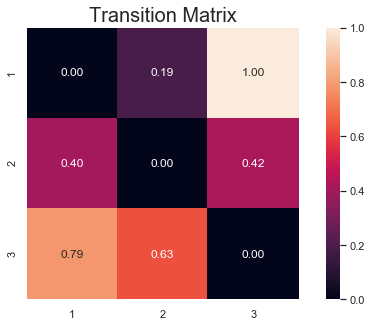

In [13]:
#transition matrix heatmap seaborn
fig, ax = plt.subplots(squeeze=False)
ax[0,0].set_title('Transition Matrix', size=20)
sns.heatmap(df_norm_matrix, square=True, annot=True, fmt=".2f");

In [14]:
#necessary for Bokeh matrix heatmap
matrix_r = df_norm_matrix.reset_index()
#transforming 2d matrix dataframe into 1d dataframe
matrix_rows = pd.melt(matrix_r, id_vars=['index'], value_vars=AOI, var_name='target_AOI')
matrix_rows

,index,target_AOI,value
0,1,1,0.000000
1,2,1,0.403846
2,3,1,0.788462
3,1,2,0.192308
4,2,2,0.000000
5,3,2,0.634615
6,1,3,1.000000
7,2,3,0.423077
8,3,3,0.000000


In [15]:
#Bokeh transition matrix (Can't get the y axis how I want it)
TOOLTIPS=[("Value", "@value"),
         ("AOI transition from", "@index"),
         ("to", "@target_AOI")]

colormap = cm.get_cmap("BuPu")
bokehpalette = [mpl.colors.rgb2hex(m) for m in colormap(np.arange(colormap.N))]
 
mapper = LinearColorMapper(palette=bokehpalette, low=df_norm_matrix.min().min(), high=df_norm_matrix.max().max())
x_range = FactorRange(factors=df_norm_matrix.columns.astype('str'))

AOI1 = list(df_norm_matrix.columns.astype('str'))

matrix_rows['target_AOI'] = matrix_rows.target_AOI.astype('str')

source = ColumnDataSource(matrix_rows)

z = figure(title="Transition Matrix", x_range=AOI1, toolbar_location='below', toolbar_sticky=False, tools=TOOLS,
          tooltips=TOOLTIPS)

z.rect(x='target_AOI', y='index', width=1, height=1, source=source
       , fill_color={'field': 'value', 'transform': mapper}, line_color=None)

color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="5pt",
                     ticker=BasicTicker(desired_num_ticks=8),
                     label_standoff=6, border_line_color=None, location=(0, 0))
z.add_layout(color_bar, 'right')
z.xaxis.axis_label = 'AOI'
z.yaxis.axis_label = 'AOI'

show(z)